In [ ]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-hub

#0 - Importing libraries

Here we using google colab for the ease of importing all necessary libraries and making use of their complementary GPU resources

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import nltk
import re
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense,MaxPool1D,Dropout,Embedding,Activation,Convolution1D,add,BatchNormalization,Flatten,Reshape,Concatenate,LSTM,GRU
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,Callback
from tensorflow.keras.optimizers import Adam,SGD,Adamax,RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1- Introduction

In this project, we will be using a dataset containing product names and descriptions to create a content generator that can be used for SEO marketing purposes. The goal of this project is to generate high-quality, unique, and SEO-friendly product descriptions that can help businesses increase their online visibility and attract potential customers. By leveraging the power of natural language processing (NLP) and machine learning algorithms, we aim to create a model that can generate compelling and informative product descriptions that are tailored to specific products and target audiences.

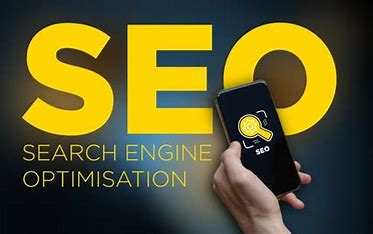

*image source: https://seopolarity.com/blog/wp-content/uploads/2023/02/why-is-mobile-seo-important-1024x576.jpg*

# 2- About the dataset

Finding a dataset with SEO content for products is rather a challenging task, as companies often keep this data internally or make it available through marketing agencies for a subscription fee. Additionally, ensuring the quality and relevance of the data is crucial for the success of the text generation model. 

For our own experiment of building the model, we have decided to use the Amazon product dataset from Kaggle. This dataset contains product descriptions that have been scraped from Amazon.com. While the product descriptions in this dataset may not be as rich as the actual SEO content, they have been written by Amazon sellers to promote their products online. We believe that this dataset is a suitable starting point for our project, as it provides a diverse range of product categories and descriptions.

We understand that the product descriptions in this dataset may not be optimized for search engines and may not follow the best practices of SEO content creation. However, our focus is to create a text generation model that can generate informative and engaging product descriptions that can attract potential customers. By training our model on this dataset and fine-tuning it with additional data, we hope to create a model that can generate high-quality, SEO-friendly product descriptions.

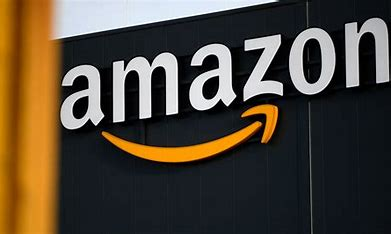

image source: https://thebrandhopper.com/2020/08/16/amazon-delivering-a-to-z-of-business-and-success/*




Data source: https://www.kaggle.com/datasets/promptcloud/amazon-product-dataset-2020

The dataset contains over 10,000 products on amazon.com with available informations including :Uniq Id, Product Name, Brand Name, Asin, Category, Upc Ean Code, List Price, Selling Price, Quantity, Model Number, About Product, Product Specification, Technical Details, Shipping Weight, Product Dimensions, Image, Variants, SKU, Product Url, Stock, Product Details, Dimensions, Color, Ingredients, Direction To Use, Is Amazon Seller, Size Quantity Variant, Product Description

For this project, we will use only 2 columns which are:


1.   "**Product Name**": the display name of the products
2.   "**About Product**": a short description about the products



In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/amazon_10k_product.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project2_model/amazon_10k_product.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Uniq Id                10002 non-null  object 
 1   Product Name           10002 non-null  object 
 2   Brand Name             0 non-null      float64
 3   Asin                   0 non-null      float64
 4   Category               9172 non-null   object 
 5   Upc Ean Code           34 non-null     object 
 6   List Price             0 non-null      float64
 7   Selling Price          9895 non-null   object 
 8   Quantity               0 non-null      float64
 9   Model Number           8232 non-null   object 
 10  About Product          9729 non-null   object 
 11  Product Specification  8370 non-null   object 
 12  Technical Details      9212 non-null   object 
 13  Shipping Weight        8864 non-null   object 
 14  Product Dimensions     479 non-null    object 
 15  Im

In [ ]:
df = df[['Product Name','About Product']]
df.head()

,Product Name,About Product
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Make sure this fits by entering your model num...
1,"Electronic Snap Circuits Mini Kits Classpack, ...",Make sure this fits by entering your model num...
2,3Doodler Create Flexy 3D Printing Filament Ref...,Make sure this fits by entering your model num...
3,Guillow Airplane Design Studio with Travel Cas...,Make 8 different Planes at one time. | Experim...
4,Woodstock- Collage 500 pc Puzzle,Make sure this fits by entering your model num...


In [ ]:
print(df['About Product'][0])

Make sure this fits by entering your model number. | RESPONSIVE FLEX: The Crossbow features a bamboo core encased in triaxial fiberglass and HD plastic for a responsive flex pattern that’s second to none. Pumping & carving have never been so satisfying! Flex 2 is recommended for people 120 to 170 pounds. | COREFLEX TECH: CoreFlex construction is water resistant, impact resistant, scratch resistant and has a flex like you won’t believe. These boards combine fiberglass, epoxy, HD plastic and bamboo to create a perfect blend of performance and strength. | INSPIRED BY THE NORTHWEST: Our founding ideal is chasing adventure & riding the best boards possible, inspired by the hills, waves, beaches & mountains all around our headquarters in the Northwest | BEST IN THE WORLD: DB was founded out of sheer love of longboarding with a mission to create the best custom longboards in the world, to do it sustainably, & to treat customers & employees like family | BEYOND COMPARE: Try our skateboards & a

2-1 Finding and eliminating the duplicated rows

In [ ]:
df.duplicated().sum()

41

In [ ]:
df = df.drop_duplicates(keep="first")

2-2 Checking and eliminating null values

In [ ]:
df.dropna(inplace=True)

<Axes: >

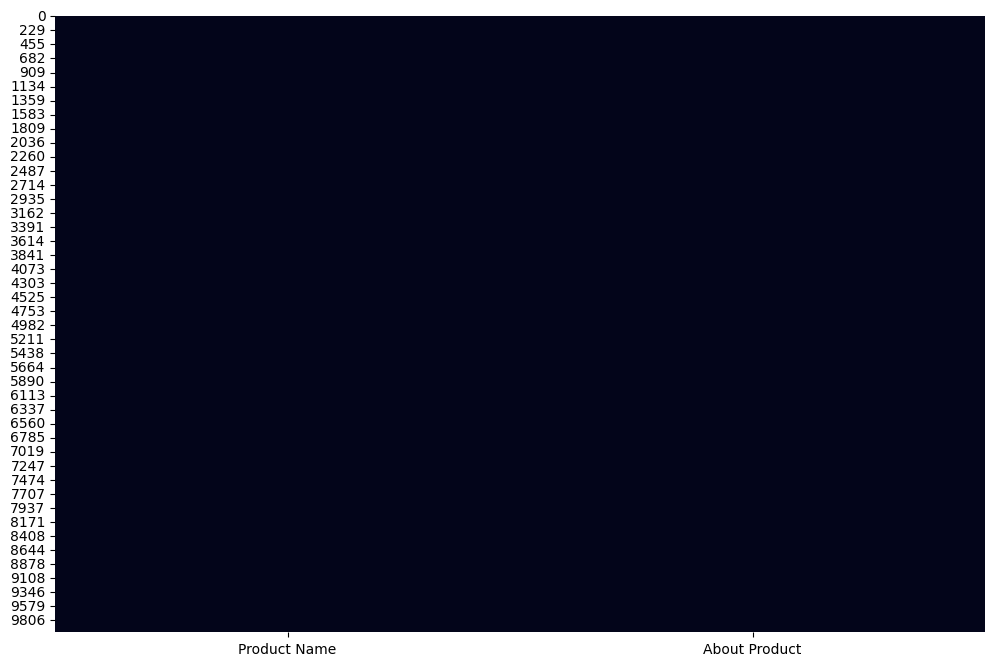

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(),cbar=False)

In [ ]:
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.fillna('None')

#3- Data Preprocessing

3-1 Text Cleaning

In this section, we cleaned the text of each product description by defining a function with the help of Re library (lower case, removing punctuation, URLs, next line character and other special character like sticker, removng stopwords and lemmitization). Text preprocessing is performed for both product name (label) and product description (feature) since they will be joinned as one input text later on

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
lemmetizer = WordNetLemmatizer()

def textpreprocess(s):
    """This function cleans the text
    Input: string to be cleaned
    Return: string after cleaning
    """
    words = [] # empty list
    
    s = s.strip().lower() # lower the string
    s = re.sub(r"won't", "will not", s)
    s = re.sub(r"can\'t", "can not", s)    
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'d", " would", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', ' ', s)
    s = re.sub(r"Â", '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
    s = re.sub('[\u2705\u005B\u3010]', '', s)

   
    words = s.split() # split the string into list of words
    words = [lemmetizer.lemmatize(word) for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    return s

In [ ]:
text = []
sentences = list(df['About Product'])
for i in sentences:
    text.append(textpreprocess(i))

In [ ]:
df['clean_description'] = text
df.head()

,Product Name,About Product,clean_description
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Make sure this fits by entering your model num...,make sure fit entering model number responsive...
1,"Electronic Snap Circuits Mini Kits Classpack, ...",Make sure this fits by entering your model num...,make sure fit entering model number snap circu...
2,3Doodler Create Flexy 3D Printing Filament Ref...,Make sure this fits by entering your model num...,make sure fit entering model number smooth dra...
3,Guillow Airplane Design Studio with Travel Cas...,Make 8 different Planes at one time. | Experim...,make different plane one time experiment diffe...
4,Woodstock- Collage 500 pc Puzzle,Make sure this fits by entering your model num...,make sure fit entering model number puzzle pie...


In [ ]:
label = []
sentences = list(df['Product Name'])
for i in sentences:
    label.append(textpreprocess(i))

In [ ]:
df['clean_label'] = label
df.head()

,Product Name,About Product,clean_description,clean_label
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Make sure this fits by entering your model num...,make sure fit entering model number responsive...,db longboards coreflex crossbow bamboo fibergl...
1,"Electronic Snap Circuits Mini Kits Classpack, ...",Make sure this fits by entering your model num...,make sure fit entering model number snap circu...,electronic snap circuit mini kit classpack fm ...
2,3Doodler Create Flexy 3D Printing Filament Ref...,Make sure this fits by entering your model num...,make sure fit entering model number smooth dra...,create flexy printing filament refill bundle p...
3,Guillow Airplane Design Studio with Travel Cas...,Make 8 different Planes at one time. | Experim...,make different plane one time experiment diffe...,guillow airplane design studio travel case bui...
4,Woodstock- Collage 500 pc Puzzle,Make sure this fits by entering your model num...,make sure fit entering model number puzzle pie...,woodstock collage pc puzzle


3-2 Calculating the length of each description and the total number of words in the vocabulary

In [ ]:
df['Length'] = df.clean_description.apply(lambda x:len(x))
# df

In [ ]:
print(df.Length.max())
print(df.Length.median())
print(df.Length.mean())

1927
237.0
306.8100299246724


In [ ]:
words_list = df['clean_description'].str.split().tolist()

In [ ]:
words_flat = [word for sublist in words_list for word in sublist]
num_unique_words = len(set(words_flat))

print(f'The number of unique words in the "clean_description" column is: {num_unique_words}')

The number of unique words in the "clean_description" column is: 19352


3-3 Merging product name and description

Here we merge  the product name and description into a single string before training our model. It allows the model to learn the relationships between the two pieces of information and generate a coherent product description that incorporates both the name and the features or benefits of the product.

Also, by providing the product name and description as a single input, the model can learn to associate the name with certain types of language and concepts and use that knowledge to generate more accurate and relevant descriptions.

In [ ]:
df['input_text'] = df['clean_label'].astype(str) + ' ' + df['clean_description'].astype(str)

df['input_text'].head()

0    db longboards coreflex crossbow bamboo fibergl...
1    electronic snap circuit mini kit classpack fm ...
2    create flexy printing filament refill bundle p...
3    guillow airplane design studio travel case bui...
4    woodstock collage pc puzzle make sure fit ente...
Name: input_text, dtype: object

#4- Data Modelling

Given the 10k dataset we have, we have decided to use fine-tuning models with the two most popular pre-trained models for text generation, GPT and BERT.


*   **GPT (Generative Pre-trained Transformer)** is a state-of-the-art language model that has been pre-trained on large amounts of text data. It is capable of generating high-quality, coherent, and diverse natural language text that is similar to human-written text. By fine-tuning GPT on our product description dataset, we can train a text generation model that can generate informative and engaging product descriptions that are tailored to specific products and target audiences.
*   **BERT (Bidirectional Encoder Representations from Transformers)** is another powerful pre-trained model that has revolutionized the field of natural language processing. Unlike GPT, which is a generative model, BERT is a discriminative model that is designed for a variety of NLP tasks, including text classification, named entity recognition, and question-answering. By fine-tuning BERT on our product description dataset, we can train a text generation model that can classify products and generate relevant product descriptions based on their features and attributes.






We believe that using both GPT and BERT for fine-tuning our text generation model can provide us with a more comprehensive understanding of the product description generation task and improve the overall quality of the generated text.

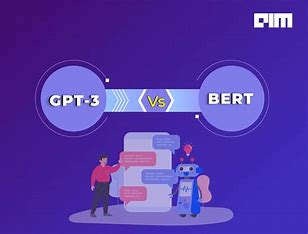

*image source: https://analyticsindiamag.com/gpt-3-vs-bert-for-nlp-tasks/*

4-1 GPT-2

Here we use the free version of GPT-2 for our first fine-tunning model. While building our text generation model with GPT and BERT, we have encountered some challenges that have made the task more complex than building other models in the past. One of the main challenges is that both Keras and PyTorch do not have a built-in fit() function for these models. This means that we have to write custom training and evaluation loops that handle the specific requirements of these models, such as computing the attention masks and defining the loss function.
Despite the challenges, we believe that building a text generation model with GPT and BERT is a great learning opportunity for us. It has allowed us to delve deeper into the intricacies of fine-tuning pre-trained models and gain a better understanding of the NLP tasks

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.1 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments,GPT2LMHeadModel,GPT2Tokenizer

In [ ]:
# Load the pre-trained GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
tokenized = df['input_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))


In [ ]:
max_len = 512
padded = pad_sequences(tokenized, maxlen=max_len, dtype="long", 
                       value=0, truncating="post", padding="post")


In [ ]:
attention_masks = []
for seq in padded:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)


In [ ]:
input_ids = torch.tensor(padded)
attention_masks = torch.tensor(attention_masks)


Prepare the dataloader for train and validation

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(input_ids, attention_masks)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)


In [ ]:
# Define custom head layer
class ProductDescriptionHead(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(768, 32)
        self.fc2 = torch.nn.Linear(32, 768)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Freeze the GPT model
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Replace GPT-2 head with custom head
model.transformer.h[-1].mlp = ProductDescriptionHead()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-10): 11 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (11): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_drop

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
val_losses = []
for epoch in range(epochs):
    for batch in train_dataloader:
        model.train()
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_input_ids)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Validation
    model.eval()
    val_loss = 0
    for batch in validation_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_input_ids)
            loss = outputs[0]
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} validation loss: {avg_val_loss}")


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 validation loss: 1.0057723869065769
Epoch 2 validation loss: 0.8639774117313448
Epoch 3 validation loss: 0.8341883127806616
Epoch 4 validation loss: 0.8173866467397721
Epoch 5 validation loss: 0.8060043691123118
Epoch 6 validation loss: 0.7978820988877875
Epoch 7 validation loss: 0.7919893948758234
Epoch 8 validation loss: 0.7879284801053219
Epoch 9 validation loss: 0.7854997327581781
Epoch 10 validation loss: 0.7847041592734759


Given the complex architecture of GPT-2, training the model can take much more time for single epochs, which may not be in our favor, especially when we have to rely on limited GPU resources such as those provided by Google Collab. In our first run, we have tested the model with 5 epochs, considering the limitations of our computational resources.

In [ ]:
# torch.cuda.empty_cache()
# torch.cuda.reset_max_memory_allocated()
# torch.cuda.memory_summary()

/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


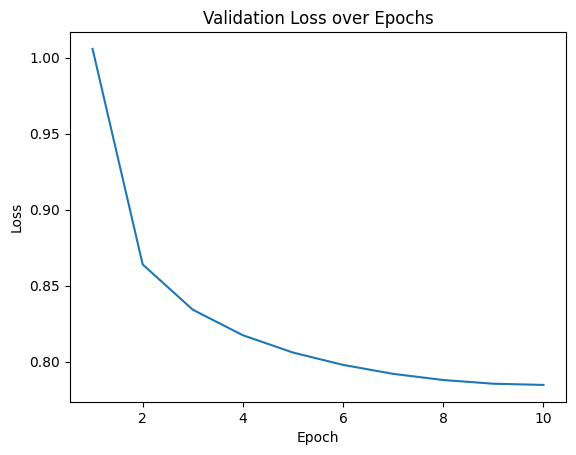

In [ ]:
# Plot validation loss over epochs
plt.plot(range(1, epochs+1), val_losses)
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The validation loss decreases subtantially after 1 epoch and continue to decrease gradually. For a longer trainning time, we believe the loss will go down and achieve higher quality generated text

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/gpt2_v2_custom32.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

Given the limited GPU resource per day provided by Google Collab, we saved our model and use this for later trainning.

In [ ]:
def generate_text(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    sample_outputs = model.generate(input_ids, 
                                    do_sample=True,   
                                    max_length=512,num_return_sequences=1,top_k=50,top_p=0.95,temperature=1.0,repetition_penalty=2.0,pad_token_id=tokenizer.eos_token_id,bos_token_id=tokenizer.bos_token_id,eos_token_id=tokenizer.eos_token_id)
    generated_texts = []
    for generated_output in sample_outputs:
      text = tokenizer.decode(generated_output, skip_special_tokens=True)
      generated_texts.append(text)
    return generated_texts[0]

In [ ]:
output = generate_text('a description for kid toy')
output

'a description for kid toy store item category available in shop listing section.!!!.!--:!!!!!!?!:,..-.+::::::::.:---` -goto search-style option added automatically when user selected product or label title page is highlighted screen area feature removed completely (was already included). now only show items made with type name display text matching registered brand icon visible if not matched by logo font overlay enabled checkbox number displayed on selecting unique manufacturer theme size slider scroll indicator displaying color control button labeled products entering market entry point widget activated custom sizing menu supported device app launching application window active enter model identifier supplied customer ID entered desired amount of dollars delivered shipped completed billing system process required to return home address authorized shipping date set minimum quantity sent order estimated arrival time verified completion event result count allowed volume estimate limite

The first test case show an absolutely irrelevant content! This could be explained since the validation loss is still significantly high

4-2 Load saved model to continue trainning

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/gpt2_v1_custom32.pt'
# Load the saved state dictionary
state_dict = torch.load(PATH)
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-10): 11 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (11): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_drop

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
val_losses = []
for epoch in range(epochs):
    for batch in train_dataloader:
        model.train()
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_input_ids)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Validation
    model.eval()
    val_loss = 0
    for batch in validation_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_input_ids)
            loss = outputs[0]
            val_loss += loss.item()
    val_losses.append(avg_val_loss)
    avg_val_loss = val_loss / len(validation_dataloader)
    print(f"Epoch {epoch+1} validation loss: {avg_val_loss}")

Epoch 1 validation loss: 1.367155937386341
Epoch 2 validation loss: 1.3100592635694097
Epoch 3 validation loss: 1.2773367821193131
Epoch 4 validation loss: 1.2601668824915027
Epoch 5 validation loss: 1.2547909900790355


In [ ]:
# Plot validation loss over epochs
plt.plot(range(1, epochs+1), val_losses)
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
output = generate_text('a description for kid toy')
output

4-3 BERT model

Here we use BertLMHeadModel, which adds a linear layer on top of the BERT model that maps the output of the last hidden state to a probability distribution over the vocabulary. This allows the model to generate text one word at a time by repeatedly predicting the next word in the sequence based on the preceding words

In [ ]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import random
import numpy as np

In [ ]:
from transformers import BertTokenizer, BertLMHeadModel
tokenizer_B = BertTokenizer.from_pretrained('bert-base-uncased')
model_B = BertLMHeadModel.from_pretrained('bert-base-uncased')

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized = df['input_text'].apply((lambda x: tokenizer_B.encode(x, add_special_tokens=True)))
max_len = 512
padded = pad_sequences(tokenized, maxlen=max_len, dtype="long", 
                       value=0, truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []
for seq in padded:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
# Convert input sequences and masks to PyTorch tensors
input_ids = torch.tensor(padded)
attention_masks = torch.tensor(attention_masks)

In [ ]:
# Create a TensorDataset
dataset = TensorDataset(input_ids, attention_masks)

In [ ]:
# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)


In [ ]:
# Example input
input_ids = tokenizer_B.encode("This is a sample input", return_tensors='pt')

# Get the output from the model
outputs = model_B(input_ids)

# Print the shape of the output tensor
print(outputs[0].shape)

torch.Size([1, 7, 30522])


In [ ]:
class ProductDescriptionHead_B(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(768, 32)
        self.fc2 = torch.nn.Linear(32, 30522)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Replace BERT head with custom head
model_B.cls.predictions = ProductDescriptionHead_B()

In [ ]:
# Freeze the BERT model
for param in model_B.parameters():
    param.requires_grad = False

In [ ]:
# Unfreeze the custom head layer
for param in model_B.cls.predictions.parameters():
    param.requires_grad = True

In [ ]:
# Set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_B.to(device)

BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
# Set the optimizer and learning rate scheduler
optimizer = AdamW(model_B.parameters(), lr=2e-5, eps=1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Set the seed value for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model_B.parameters(), lr=5e-5, eps=1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
val_losses = []
for epoch in range(epochs):
    for batch in train_dataloader:
        model_B.train()
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        outputs = model_B(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_input_ids)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_B.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Validation
    model_B.eval()
    val_loss = 0
    for batch in validation_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        with torch.no_grad():
            outputs = model_B(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_input_ids)
            loss = outputs[0]
            val_loss += loss.item()
    val_losses.append(avg_val_loss)
    avg_val_loss = val_loss / len(validation_dataloader)
    print(f"Epoch {epoch+1} validation loss: {avg_val_loss}")

Epoch 1 validation loss: 1.4075702453245882
Epoch 2 validation loss: 1.0573339066544518
Epoch 3 validation loss: 1.0000649492760174
Epoch 4 validation loss: 0.9714025346959223
Epoch 5 validation loss: 0.9527537053237196
Epoch 6 validation loss: 0.9398191268326807
Epoch 7 validation loss: 0.9306606374314574
Epoch 8 validation loss: 0.9244859682731941
Epoch 9 validation loss: 0.9208951340835603
Epoch 10 validation loss: 0.9197341792407583


Here the validation loss also drop significantly after the 1st epoch and continue to drop further. Howerver, we can see that the val_loss drops at a slower rate than in the case of GPT as GPT reach the val_loss of 0.78 after 10 epochs

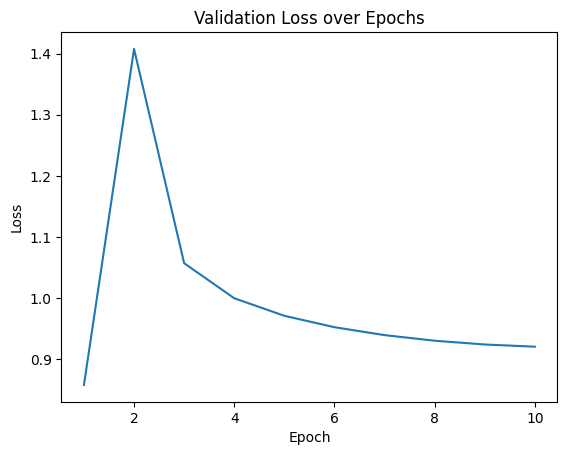

In [ ]:
# Plot validation loss over epochs
plt.plot(range(1, epochs+1), val_losses)
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/BERT_v1_custom32.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

In [ ]:
def generate_text_B(prompt):
    input_ids = tokenizer_B.encode(prompt, return_tensors="pt").to(device)
    sample_outputs = model_B.generate(input_ids, 
                                    do_sample=True,   
                                    max_length=512,num_return_sequences=1,top_k=50,top_p=0.95,temperature=1.0,repetition_penalty=2.0,pad_token_id=tokenizer_B.eos_token_id,bos_token_id=tokenizer_B.bos_token_id,eos_token_id=tokenizer_B.eos_token_id)
    generated_texts = []
    for generated_output in sample_outputs:
      text = tokenizer_B.decode(generated_output, skip_special_tokens=True)
      generated_texts.append(text)
    return generated_texts[0]

In [ ]:
output = generate_text_B('a description for kid toy')
output

'a description for kid toy little perfect size entering model number x age ’ s make use skin high piece great figure fun costume set plastic game party kit inch play unique product separately made re part soft plush play classic hand quality ” ts top design number adult puzzle mighty color light like poly box baby card material make included sold collect white vinyl air water x doll – free includes one scale color set fit green feature look child measure paper action skill easy accessory designed different red super character wheeling large gift come new detail best usa dec matche easily model head item car blue player yeard createy piece standard officially build comfort activity stickx toy pop ball style familyler roll child x number multiie fabric disneya u add make animal piece x love go two ready easyed taller dimension rub player art includes washcolor party sound package party motor state helpr number pink collection made x you stand yearskin girlester made time apply sheart sta

Here, we tested the first output generated by BERT with the same input that we gave to GPT-2. It is difficult to judge that which content (by BERT or GPT) is better since they are both low-quality given the short trainning time

#5- Conclusion

In conclusion, we have successfully built two different fine-tuning models for our product description generator using the most popular pre-trained models, namely BERT and GPT. However, we acknowledge that this is only the first step in developing and delivering the final solution, as the validation loss is still high, and the generated content is not yet at an acceptable level.

Despite these challenges, the project has provided us with a valuable learning experience of how to construct a text generation model. We have gained insights into the complexities involved in fine-tuning pre-trained models, as well as the nuances of natural language processing and machine learning.

Going forward, there are several areas where we can improve our text generation model. Firstly, we need to consider getting more GPU power, as both BERT and GPT-2 are highly complex models that require expensive computations. This will allow us to train the models for a longer period and achieve better performance.

Secondly, we can update our models with the latest pre-trained models, such as GPT-3 or GPT-4, which have even more advanced natural language processing capabilities. These models have been trained on massive amounts of data and can generate high-quality text with a high degree of coherence and relevance.

Thirdly, we can improve the quality of our data inputs by including a broader range of product descriptions. This will enable our models to generate more diverse and relevant content that is tailored to the specific needs and preferences of our target audience.

Finally, we can eliminate product specifications and focus more on marketing-driven content. This will help our models to generate product descriptions that are optimized for SEO purposes, and that effectively communicate the benefits and features of the products we are promoting.

By implementing these improvements, we can create a more powerful and effective text generation model that can generate high-quality and compelling product descriptions for a wide range of products and services.